### Описание задачи

ссылка - https://semantic-textual-relatedness.github.io/
Задача по автоматическому определению степени семанической связанности между парами предложений. Предложения представлены на различных языках (мы возьмем английский).

Два предложения считаются семантически схожими, когда у них есть парафразное или подразумевающее отношение. С другой стороны, связанность - это гораздо более широкое понятие, которое учитывает все общие черты между двумя предложениями: посвящены ли они одной теме, выражают ли одну и ту же точку зрения, относятся ли к одному и тому же периоду времени, одно развивает другое (или вытекает из него) и т.д. Например, для следующих пар предложений:
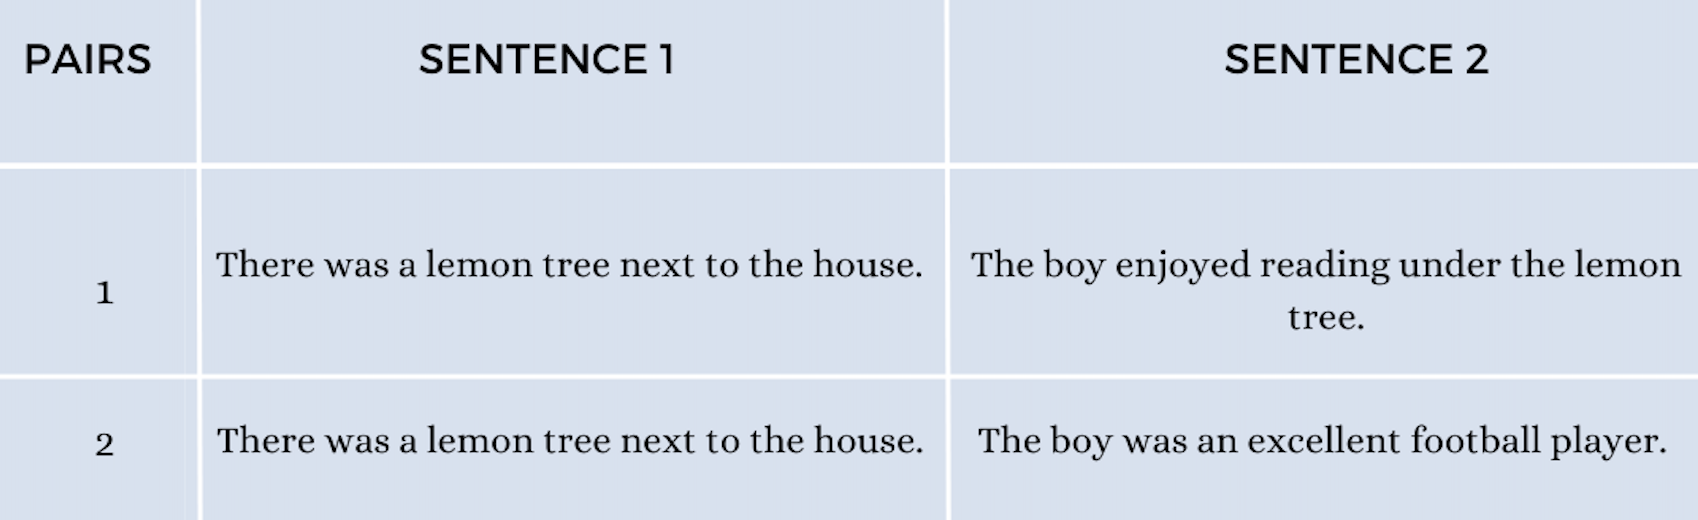
Большинство скажут, что 1-я пара более связана, чем вторая

Нам нужно определеить семантическую связанность двух предложений, оценивая это от 0 до 1, где 0 - не связанны вообще, а 1 максимально связанные


### Данные

Нам даны 2 текстовых признака - предложения и 1 числовой - насколько схожи эти два предложения.

Целевой признак у нас это именно последний. Он может принимать дробное значение от 0 до 1 включительно.

### Измерение качества

Официальной метрикой оценки для этого задания является коэффициент ранговой корреляции Спирмена, который отражает, насколько хорошо предсказанные системой рейтинги тестовых экземпляров согласуются с суждениями человека. 

Код оценки - https://github.com/semantic-textual-relatedness/Semantic_Relatedness_SemEval2024/blob/main/evaluation_script/evaluation.py

In [77]:
# тут предварительный анализ данных 
# (есть ошибки, сбалансированы ли классы, можно как-то просто решить - например есть ли там одинковые слова)

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import re
plt.style.use('ggplot')

In [2]:
# Load the File
train_str_rel = pd.read_csv('eng_train.csv')
train_str_rel.head()

,PairID,Text,Score
0,ENG-train-0000,"It that happens, just pull the plug.\nif that ...",1.0
1,ENG-train-0001,A black dog running through water.\nA black do...,1.0
2,ENG-train-0002,I've been searchingthe entire abbey for you.\n...,1.0
3,ENG-train-0003,If he is good looking and has a good personali...,1.0
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...",1.0


In [3]:
def prepare_table(df: pd.DataFrame):
    temp = df['Text'].apply(lambda x: x.split("\n")).tolist()
    text1 = []
    text2 = []
    for i in temp:
        text1.append(i[0])
        text2.append(i[1])
    df['Text_1'] = text1
    df['Text_2'] = text2
    df = df[['PairID', 'Text_1', 'Text_2', 'Score']]
    return df

In [4]:
# Creating a column "Split_Text" which is a list of two sentences.
train_str_rel = prepare_table(train_str_rel)
train_str_rel.head()

,PairID,Text_1,Text_2,Score
0,ENG-train-0000,"It that happens, just pull the plug.","if that ever happens, just pull the plug.",1.0
1,ENG-train-0001,A black dog running through water.,A black dog is running through some water.,1.0
2,ENG-train-0002,I've been searchingthe entire abbey for you.,I'm looking for you all over the abbey.,1.0
3,ENG-train-0003,If he is good looking and has a good personali...,"If he's good looking, and a good personality, ...",1.0
4,ENG-train-0004,"She does not hate you, she is just annoyed wit...","She doesn't hate you, she is just annoyed.",1.0


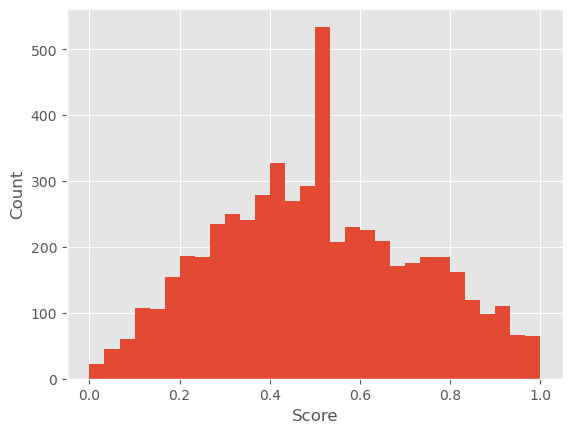

In [5]:
plt.hist(train_str_rel['Score'], bins=30)
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

Распределение по целевой функции немного похоже на нормальное с сильным отрывом 0.5 от остальных значений

Давайте посмотрим какую-то базовую идею. Просто посмотрим как много там одинаковых слов (нужно удалить частые слова)

In [7]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
scores = []
for i in range(len(train_str_rel)):
    text_1 = train_str_rel.loc[i]['Text_1']
    text_2 = train_str_rel.loc[i]['Text_2']
    text_1 = re.sub('[,.!?:-]', '', text_1)
    text_2 = re.sub('[,.!?:-]', '', text_2)
    words_1 = set(text_1.split(' '))
    words_2 = set(text_2.split(' '))
    for j in stop_words:
        if (j in words_1):
            words_1.remove(j)
        if (j in words_2):
            words_2.remove(j)
    words = set(text_1 + text_2)
    scores.append(len(words_1.intersection(words_2)) / len(words))

In [8]:
from sklearn.metrics import mean_squared_error

mean_squared_error(train_str_rel['Score'], scores)

0.21406993960867005

Вышло не очень

### статьи по этой задаче

Например эта https://www.researchgate.net/publication/272088094_A_SEMANTIC_SIMILARITY_MEASURE_BETWEEN_SENTENCES

### тут рассказываем какую модель выбрали и почему